# Language Classification

This notebook contains the code for a CNN that classifies spoken language.

Used as reference:

https://github.com/pietz/language-recognition/blob/master/Language%20Classifier.ipynb

https://github.com/sergeyvilov/MCV-spoken-language-recognition/blob/master/audio_models.py

https://towardsdatascience.com/spoken-language-recognition-on-mozilla-common-voice-part-ii-models-b32780ea1ee4

https://towardsdatascience.com/spoken-language-recognition-on-mozilla-common-voice-part-i-3f5400bbbcd8

https://github.com/zkmkarlsruhe/language-identification/tree/main

## Data Loading


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tqdm import tqdm

### Languages to Detect


In [3]:
np.random.seed(1)
# langs = ["ar", "de", "en", "es", "fr", "hi", "it", "ja", "ru", "zh-CN"]
# remove arabic, hindi, japanese, russian, chinese
from languages import LANGUAGES

langs = ["de", "en", "es", "fr", "it"]
# langs = ["de", "en"]
lang_nums = {lang: index for index, lang in enumerate(langs)}

num_to_lang = {v: k for k, v in lang_nums.items()}
for lang in langs:
    print(LANGUAGES[lang])

IMAGE_DIMENSIONS = (13, 250, 1)
# IMAGE_DIMENSIONS = (13, 1000, 1)

German
English
Spanish
French
Italian


### Load Spectrograms


In [4]:
def load_images_from_path(path, label, num_images=1000, shuffle=True):
    images = []
    labels = []

    count = 0
    files = os.listdir(path)
    if shuffle:
        files = np.random.choice(files, num_images, replace=False)
    else:
        files = files[:num_images]
    for file in tqdm(files):
        # print(f"{count} - {file}")
        if count >= num_images:
            break
        try:
            img = image.img_to_array(
                image.load_img(
                    os.path.join(path, file),
                    target_size=(IMAGE_DIMENSIONS[0], IMAGE_DIMENSIONS[1], 3),
                ).convert("L")
            )
            img = img.reshape(IMAGE_DIMENSIONS)
            # from 255 to 0-1
            img = img / 255
            images.append(img)
            labels.append((label))
            count += 1
        except Exception as e:
            print(f"Error loading image: {file}")
            print(e)

    return images, labels


def show_images(images, label):
    fig, axes = plt.subplots(
        1, 8, figsize=(20, 20), subplot_kw={"xticks": [], "yticks": []}
    )

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        # ax.imshow(images[i] / 255)
        ax.set_title(LANGUAGES[num_to_lang[labels[i]]])  # Set the title for the subplot

German


100%|██████████| 92740/92740 [00:23<00:00, 3940.38it/s]


English


100%|██████████| 92740/92740 [00:27<00:00, 3346.23it/s]


Spanish


100%|██████████| 92740/92740 [00:24<00:00, 3771.74it/s]


French


100%|██████████| 92740/92740 [00:24<00:00, 3792.92it/s]


Italian


100%|██████████| 92740/92740 [00:23<00:00, 3944.44it/s]


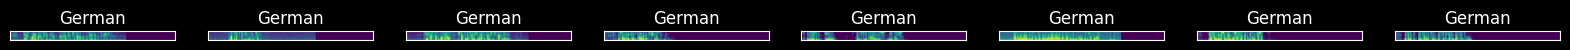

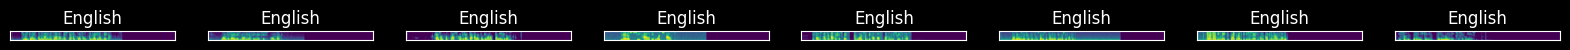

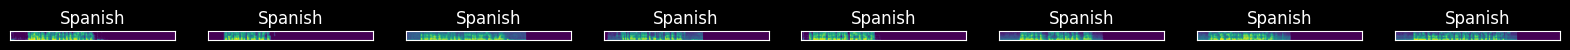

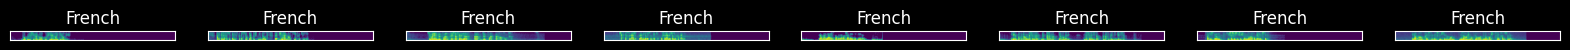

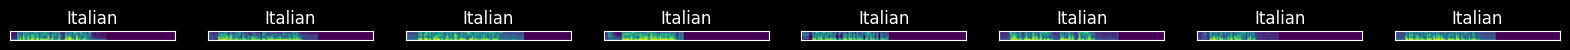

In [5]:
mm = []
y = []
NUM_IMGS = 92_740
# NUM_IMGS = 50_000

for lang in langs:
    print(LANGUAGES[lang])
    path = f"data/spectrogram/{lang}_train_new/"
    images, labels = load_images_from_path(
        path, lang_nums[lang], num_images=NUM_IMGS, shuffle=False
    )
    mm += images
    y += labels
    show_images(images, labels)

## Data Splitting


In [6]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [7]:
tf.random.set_seed(1)

x_train, x_test, y_train, y_test = train_test_split(
    mm, y, stratify=y, test_size=0.2, random_state=0, shuffle=True
)

x_train_arr = np.array(x_train)
x_test_arr = np.array(x_test)

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [8]:
# truncate dataset for faster training:
x_train_arr = x_train_arr[:NUM_IMGS]
x_test_arr = x_test_arr[:NUM_IMGS]
y_train_encoded = y_train_encoded[:NUM_IMGS]
y_test_encoded = y_test_encoded[:NUM_IMGS]
print(x_train_arr.shape)
print(y_train_encoded.shape)

(92740, 13, 250, 1)
(92740, 5)


In [9]:
print(x_train_arr.shape)
print(y_train_encoded.shape)
print(x_test_arr.shape)
print(y_test_encoded.shape)
# print number per class
print(np.unique(y_train, return_counts=True))
print(np.unique(y_train_encoded, return_counts=True))

(92740, 13, 250, 1)
(92740, 5)
(92740, 13, 250, 1)
(92740, 5)
(array([0, 1, 2, 3, 4]), array([74192, 74192, 74192, 74192, 74192]))
(array([0., 1.], dtype=float32), array([370960,  92740]))


(13, 250, 1)


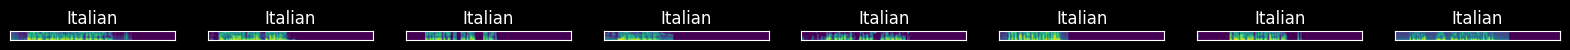

In [10]:
show_images(x_train_arr, y_train)
print(IMAGE_DIMENSIONS)

### Make sure data remains consistent between runs


In [11]:
import hashlib

hash_x_train = hashlib.sha256(str(x_train_arr).encode("utf-8")).hexdigest()
hash_x_test = hashlib.sha256(str(x_test_arr).encode("utf-8")).hexdigest()
hash_y_train = hashlib.sha256(str(y_train_encoded).encode("utf-8")).hexdigest()
hash_y_test = hashlib.sha256(str(y_test_encoded).encode("utf-8")).hexdigest()

# set this to false if you want it to remain consistent run-to-run
# for experimentation and modification without being stopped, set to true
update_hash = True

if update_hash:
    with open("./hashes/hash_x_train.txt", "w") as f:
        f.write(hash_x_train)
    with open("./hashes/hash_x_test.txt", "w") as f:
        f.write(hash_x_test)
    with open("./hashes/hash_y_train.txt", "w") as f:
        f.write(hash_y_train)
    with open("./hashes/hash_y_test.txt", "w") as f:
        f.write(hash_y_test)

with open("./hashes/hash_x_train.txt", "r") as f:
    expected_hash_x_train = f.read()
with open("./hashes/hash_x_test.txt", "r") as f:
    expected_hash_x_test = f.read()
with open("./hashes/hash_y_train.txt", "r") as f:
    expected_hash_y_train = f.read()
with open("./hashes/hash_y_test.txt", "r") as f:
    expected_hash_y_test = f.read()

# Check if the computed hashes match the expected values
assert (
    hash_x_train == expected_hash_x_train
), f"Hash of x does not match the expected value: {expected_hash_x_train}"
assert (
    hash_x_test == expected_hash_x_test
), f"Hash of x does not match the expected value: {expected_hash_x_test}"
assert (
    hash_y_train == expected_hash_y_train
), f"Hash of y does not match the expected value: {expected_hash_y_train}"
assert (
    hash_y_test == expected_hash_y_test
), f"Hash of y does not match the expected value: {expected_hash_y_test}"
print("OK")

OK


## Models


In [12]:
from keras.models import Model, Sequential
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Input,
    TimeDistributed,
    GRU,
)

In [13]:
# sequentialModel = Sequential()
# sequentialModel.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMAGE_DIMENSIONS)))
# sequentialModel.add(MaxPooling2D(2, 2))
# sequentialModel.add(Conv2D(128, (3, 3), activation="relu"))
# sequentialModel.add(MaxPooling2D(2, 2))
# sequentialModel.add(Conv2D(128, (3, 3), activation="relu"))
# sequentialModel.add(MaxPooling2D(2, 2))
# sequentialModel.add(Conv2D(128, (3, 3), activation="relu"))
# sequentialModel.add(MaxPooling2D(2, 2))
# sequentialModel.add(Flatten())
# sequentialModel.add(Dense(1024, activation="relu"))
# sequentialModel.add(Dense(len(langs), activation="softmax"))
sequentialModel = Sequential()
sequentialModel.add(
    Conv2D(32, (3, 3), activation="relu", strides=(1, 1), input_shape=IMAGE_DIMENSIONS)
)
sequentialModel.add(Conv2D(64, (3, 3), activation="relu", strides=(1, 2)))
sequentialModel.add(Conv2D(64, (3, 3), activation="relu", strides=(1, 1)))
sequentialModel.add(Conv2D(128, (1, 3), activation="relu", strides=(1, 2)))
sequentialModel.add(Flatten())
sequentialModel.add(Dense(1024, activation="relu"))
sequentialModel.add(Dropout(0.5))
sequentialModel.add(Dense(len(langs), activation="softmax"))


seqOpt = tf.keras.optimizers.legacy.Nadam(learning_rate=1e-3)
sequentialModel.compile(
    optimizer=seqOpt, loss="categorical_crossentropy", metrics=["accuracy"]
)
sequentialModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 248, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 123, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 121, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 60, 128)        24704     
                                                                 
 flatten (Flatten)           (None, 53760)             0         
                                                                 
 dense (Dense)               (None, 1024)              55051264  
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [14]:
# architecture from
# https://github.com/pietz/language-recognition/blob/master/Language%20Classifier.ipynb
in_dim = IMAGE_DIMENSIONS  # 13x1000 grayscale images (1 color channel)

i = Input(shape=in_dim)
m = Conv2D(16, (3, 3), activation="elu", padding="same")(i)
m = MaxPooling2D()(m)
m = Conv2D(32, (3, 3), activation="elu", padding="same")(m)
m = MaxPooling2D()(m)
m = Conv2D(64, (3, 3), activation="elu", padding="same")(m)
# m = MaxPooling2D()(m)
m = Conv2D(128, (3, 3), activation="elu", padding="same")(m)
# m = MaxPooling2D()(m)
m = Conv2D(256, (3, 3), activation="elu", padding="same")(m)
# m = MaxPooling2D()(m)
m = Flatten()(m)
m = Dense(512, activation="elu")(m)
m = Dropout(0.5)(m)
o = Dense(len(langs), activation="softmax")(m)

githubModel = Model(inputs=i, outputs=o)

gitOpt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
githubModel.compile(
    loss="categorical_crossentropy", optimizer=gitOpt, metrics=["accuracy"]
)
githubModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 250, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 250, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 125, 16)        0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 62, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 62, 64)         18496 

In [15]:
# in_dim = IMAGE_DIMENSIONS  # 13x1000 grayscale images (1 color channel)
# i = Input(shape=in_dim)
# m = Conv2D(16, (3, 3), activation="elu", padding="same")(i)
# m = MaxPooling2D()(m)
# m = Conv2D(32, (3, 3), activation="elu", padding="same")(m)
# m = MaxPooling2D()(m)
# m = Conv2D(64, (2, 3), activation="elu", padding="same")(m)
# m = MaxPooling2D()(m)
# m = Flatten()(m)
# m = Dense(512, activation="elu")(m)
# m = Flatten()(m)
# m = Dropout(0.5)(m)
# o = Dense(len(langs), activation="softmax")(m)

i = Input(shape=IMAGE_DIMENSIONS)
m = Conv2D(16, (3, 3), activation="elu", padding="same")(i)
m = MaxPooling2D()(m)
m = Conv2D(32, (3, 3), activation="elu", padding="same")(m)
m = MaxPooling2D()(m)
m = Conv2D(64, (2, 3), activation="elu", padding="same")(m)
m = MaxPooling2D()(m)
m = Conv2D(128, (1, 3), activation="elu", padding="same")(m)
m = Flatten()(m)
m = Dense(512, activation="elu")(m)
m = Flatten()(m)
m = Dropout(0.5)(m)
o = Dense(len(langs), activation="softmax")(m)

cnn = Model(inputs=i, outputs=o)

cnopt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
cnn.compile(loss="categorical_crossentropy", optimizer=cnopt, metrics=["accuracy"])
cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 13, 250, 1)]      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 250, 16)       160       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 125, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 125, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 3, 62, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 62, 64)         1235

In [16]:
# Define the spectrogram shape at the input
# input_shape = IMAGE_DIMENSIONS  # 13 - height, 1000 - width, 1 - grayscale

# Create a Sequential model
crnn_model = Sequential()

# Add 2D convolution layer
crnn_model.add(
    Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=IMAGE_DIMENSIONS)
)

crnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# dropout layer for regularization
crnn_model.add(Dropout(0.25))

crnn_model.add(TimeDistributed(Flatten()))

# add GRU layer
crnn_model.add(GRU(128, return_sequences=False))

crnn_model.add(Dropout(0.5))

crnn_model.add(Dense(len(langs), activation="softmax"))
opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3) # last tested on 1e-4, got like 1 for loss
crnn_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
crnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 11, 248, 32)       320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 5, 124, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 5, 124, 32)        0         
                                                                 
 time_distributed (TimeDist  (None, 5, 3968)           0         
 ributed)                                                        
                                                                 
 gru (GRU)                   (None, 128)               1573632   
                                                                 
 dropout_4 (Dropout)         (None, 128)              

In [17]:
rnn = Sequential()

rnn.add(
    GRU(
        256,
        return_sequences=True,
        input_shape=(IMAGE_DIMENSIONS[0], IMAGE_DIMENSIONS[1]),
    )
)
rnn.add(GRU(256, return_sequences=True))
rnn.add(GRU(256))

# Add a fully connected layer
rnn.add(Dense(256, activation="relu"))
rnn.add(Dense(256, activation="relu"))

# Output Layer - softmax activation function for multi-class classification
rnn.add(Dense(len(langs), activation="softmax"))

# Compile the model
rnn.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 13, 256)           390144    
                                                                 
 gru_2 (GRU)                 (None, 13, 256)           394752    
                                                                 
 gru_3 (GRU)                 (None, 256)               394752    
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1312517 (5.01 MB)
Trainable params: 1312

In [18]:
"""
:author:
Paul Bethge (bethge@zkm.de)
2021

:License:
This package is published under Simplified BSD License.
"""

# https://github.com/douglas125/SpeechCmdRecognition/blob/master/SpeechModels.py

from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Input, Dense, LSTM, Conv2D, Bidirectional
from tensorflow.keras.layers import Lambda, Dot, Softmax
from tensorflow.keras.models import Model

import tensorflow.keras.backend as K

# from src.utils.training_utils import get_feature_layer


def create_model():
    """
    This code is heavily borrowed from <https://github.com/douglas125/SpeechCmdRecognition>.
    """
    # inputs = Input((IMAGE_DIMENSIONS[1], IMAGE_DIMENSIONS[0], 1), name="input")
    # height, length, channels
    i = Input(shape=IMAGE_DIMENSIONS, name="input")
    x = BatchNormalization()(i)

    x = Conv2D(10, (5, 1), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (5, 1), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)

    x = Lambda(lambda q: K.squeeze(q, -1), name="squeeze_last_dim")(x)

    x = Bidirectional(LSTM(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]
    x = Bidirectional(LSTM(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]

    xFirst = Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = Dense(128)(xFirst)

    # dot product attention
    attScores = Dot(axes=[1, 2])([query, x])
    attScores = Softmax(name="attSoftmax")(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = Dense(64, activation="relu")(attVector)
    # x = Dropout(0.25)(x)
    x = Dense(32)(x)
    # x = Dropout(0.25)(x)

    output = Dense(len(langs), activation="softmax", name="output")(x)

    model = Model(inputs=[i], outputs=[output])

    return model


attrnn = create_model()
attrnn_opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
attrnn.compile(
    optimizer=attrnn_opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
print(attrnn.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 13, 250, 1)]         0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 13, 250, 1)           4         ['input[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 conv2d_14 (Conv2D)          (None, 13, 250, 10)          60        ['batch_normalization[0][0]'] 
                                                                                                  
 batch_normalization_1 (Bat  (None, 13, 250, 10)          40        ['conv2d_14[0][0]']     

## Torch


In [19]:
# TODO

## Keras Train


In [20]:
from keras.callbacks import EarlyStopping

earlyStopping = EarlyStopping(
    monitor="val_loss", patience=4, verbose=0, mode="min", restore_best_weights=True
)
# specify models to train
seq = {
    "model": sequentialModel,
    "name": "sequential",
    "epochs": 10,
    "batch_size": 8,
}
git = {
    "model": githubModel,
    "name": "github",
    "epochs": 10,
    "batch_size": 16,
}
crnn = {
    "model": crnn_model,
    "name": "crnn",
    "epochs": 15,
    "batch_size": 16,
}
cnn = {
    "model": cnn,
    "name": "cnn",
    "epochs": 10,
    "batch_size": 32,
}
rnn = {
    "model": rnn,
    "name": "rnn",
    "epochs": 100,
    "batch_size": 64,
}
attrnn = {
    "model": attrnn,
    "name": "attrnn",
    "epochs": 100,
    "batch_size": 64,
}

### Train Models


In [21]:
# models = [cnn, rnn, crnn, seq, git]
models = [cnn]

histories = []
for model_dict in models:
    print(f"Training {model_dict['name']}")
    history = model_dict["model"].fit(
        x_train_arr,
        y_train_encoded,
        validation_data=(x_test_arr, y_test_encoded),
        batch_size=model_dict["batch_size"],
        epochs=model_dict["epochs"],
        verbose=1,
        callbacks=earlyStopping,
    )
    histories.append((model_dict["name"], history))
    print(f"Finished training {model_dict['name']}")

Training cnn
Epoch 1/10
2899/2899 [==============================] - 72s 25ms/step - loss: 1.1523 - accuracy: 0.5368 - val_loss: 0.9288 - val_accuracy: 0.6417
Epoch 2/10
2899/2899 [==============================] - 71s 24ms/step - loss: 0.8697 - accuracy: 0.6683 - val_loss: 0.8143 - val_accuracy: 0.6907
Epoch 3/10
2899/2899 [==============================] - 71s 24ms/step - loss: 0.7755 - accuracy: 0.7091 - val_loss: 0.7888 - val_accuracy: 0.7034
Epoch 4/10
2899/2899 [==============================] - 72s 25ms/step - loss: 0.7205 - accuracy: 0.7313 - val_loss: 0.7277 - val_accuracy: 0.7282
Epoch 5/10
2899/2899 [==============================] - 68s 24ms/step - loss: 0.6830 - accuracy: 0.7442 - val_loss: 0.7277 - val_accuracy: 0.7317
Epoch 6/10
2899/2899 [==============================] - 72s 25ms/step - loss: 0.6568 - accuracy: 0.7547 - val_loss: 0.6922 - val_accuracy: 0.7445
Epoch 7/10
2899/2899 [==============================] - 233s 80ms/step - loss: 0.6351 - accuracy: 0.7638 - val_

## Keras Results


In [22]:
def plot_accuracy(name, history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "-", label=f"{name} Training Accuracy")
    plt.plot(epochs, val_acc, ":", label=f"{name} Validation Accuracy")
    plt.title(f"{name} Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")
    plt.plot()
    plt.show()


def plot_loss(name, history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "-", label=f"{name} Training Loss")
    plt.plot(epochs, val_loss, ":", label=f"{name} Validation Loss")
    plt.title(f"{name} Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper left")
    plt.plot()
    plt.show()

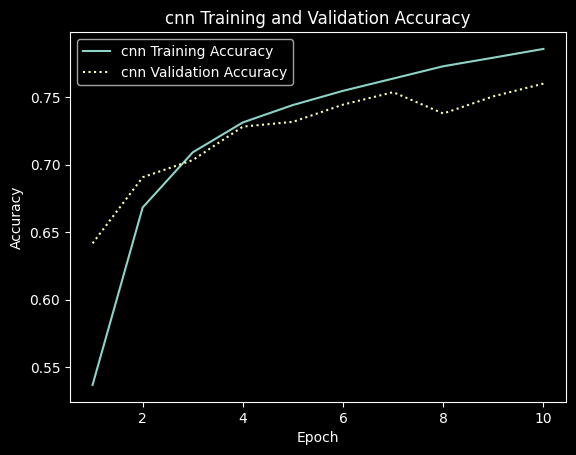

In [23]:
for history in histories:
    plot_accuracy(name=history[0], history=history[1])

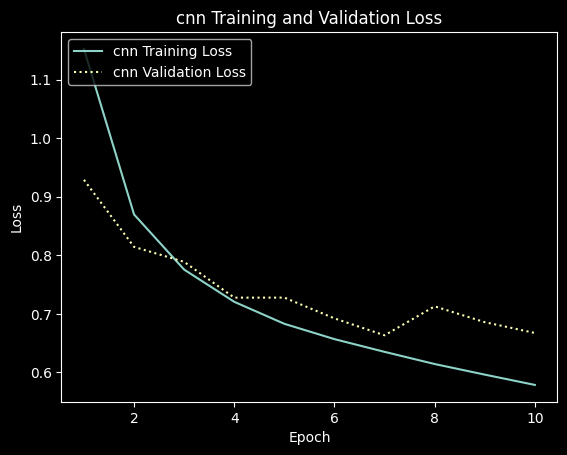

In [24]:
for history in histories:
    plot_loss(name=history[0], history=history[1])

In [25]:
for crnn_model in models:
    print(f"Saving {crnn_model['name']} to {crnn_model['name']}_lang_classifier.keras")
    crnn_model["model"].save(f"{crnn_model['name']}_lang_classifier.keras")

Saving cnn to cnn_lang_classifier.keras


In [26]:
loss_acc = []
for crnn_model in models:
    print(f"Evaluating {crnn_model['name']}")
    [loss, accuracy] = crnn_model["model"].evaluate(
        x_test_arr, y_test_encoded, verbose=1
    )
    loss_acc.append((crnn_model["name"], loss, accuracy))
    print(f"{crnn_model['name']} Loss: {loss}")
    print(f"{crnn_model['name']} Accuracy: {accuracy * 100:.2f}%")

    # compare to random:
    random_accuracy = 1 / len(langs)
    print(f"Random Accuracy: {random_accuracy * 100:.2f}%")
    print(f"Difference: {(accuracy - random_accuracy) * 100:.2f}%")

Evaluating cnn
2899/2899 [==============================] - 20s 7ms/step - loss: 0.6674 - accuracy: 0.7601
cnn Loss: 0.6673745512962341
cnn Accuracy: 76.01%
Random Accuracy: 20.00%
Difference: 56.01%


In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [28]:
sns.set()
label_encoder = LabelEncoder()
y_preds = []
for crnn_model in models:
    y_preds.append(crnn_model["model"].predict(x_test_arr))

2899/2899 [==============================] - 20s 7ms/step


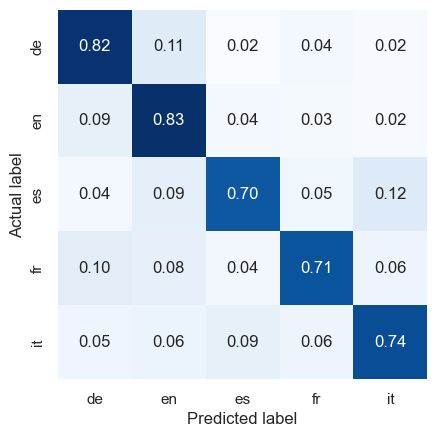

In [29]:
for y_predicted in y_preds:
    test = label_encoder.fit_transform(
        y_test_encoded.argmax(axis=1)
    )  # Replace y_test with your actual labels
    pred = label_encoder.transform(y_predicted.argmax(axis=1))

    mat = confusion_matrix(test, pred, normalize="true")

    sns.heatmap(
        mat,
        square=True,
        annot=True,
        fmt=".2f",
        cbar=False,
        cmap="Blues",
        xticklabels=langs,
        yticklabels=langs,
    )

    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")
    plt.show()